# Comparative Nutritional Analysis: Fast Food vs. Regular Food

**Project:** IS477 Food Health Analysis  
**Goal:** Distinguish between healthy and unhealthy foods using EDA and visualization, specifically identifying key nutritional differentiators.

**Note:** This notebook assumes data has been acquired and verified via the `scripts/acquire_data.py` automation pipeline.

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration for reproducibility
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Expected File Paths (from Snakemake workflow)
FILES = {
    "fastfood": "fastfood.csv",
    "usda": "food.csv",
    "yazio": "FOOD-DATA-GROUP1.csv"
}

## 1. Data Loading & Cleaning
We load the three datasets generated by the acquisition workflow and map their specific column names to a unified schema.

In [2]:
try:
    df_ff = pd.read_csv(FILES['fastfood'])
    df_usda = pd.read_csv(FILES['usda'])
    df_yazio = pd.read_csv(FILES['yazio'])
    print(f"Successfully loaded: Fast Food ({df_ff.shape}), USDA ({df_usda.shape}), Yazio ({df_yazio.shape})")
except FileNotFoundError as e:
    raise Exception("Data files not found. Please run the Snakemake acquisition workflow first.")

# --- 1. Clean Fast Food Data ---
df_ff_clean = df_ff.rename(columns={
    'item': 'Name',
    'calories': 'Calories',
    'total_fat': 'Total_Fat',
    'sat_fat': 'Saturated_Fat',
    'sodium': 'Sodium',
    'sugar': 'Sugar',
    'fiber': 'Fiber',
    'protein': 'Protein'
})[['Name', 'Calories', 'Total_Fat', 'Saturated_Fat', 'Sodium', 'Sugar', 'Fiber', 'Protein']].copy()
df_ff_clean['Type'] = 'Fast Food'

# --- 2. Clean USDA Data (Regular Food) ---
df_usda_clean = df_usda.rename(columns={
    'Description': 'Name',
    'Data.Kilocalories': 'Calories',
    'Data.Fat.Total Lipid': 'Total_Fat',
    'Data.Fat.Saturated Fat': 'Saturated_Fat',
    'Data.Major Minerals.Sodium': 'Sodium',
    'Data.Sugar Total': 'Sugar',
    'Data.Fiber': 'Fiber',
    'Data.Protein': 'Protein'
})[['Name', 'Calories', 'Total_Fat', 'Saturated_Fat', 'Sodium', 'Sugar', 'Fiber', 'Protein']].copy()
df_usda_clean['Type'] = 'Regular Food (USDA)'

# --- 3. Clean Yazio Data (Regular Food Group 1) ---
# Inspecting column names usually found in this dataset
df_yazio_clean = df_yazio.rename(columns={
    'food': 'Name',
    'Caloric Value': 'Calories',
    'Fat': 'Total_Fat',
    'Saturated Fats': 'Saturated_Fat',
    'Sodium': 'Sodium',
    'Sugars': 'Sugar',
    'Dietary Fiber': 'Fiber',
    'Protein': 'Protein'
})[['Name', 'Calories', 'Total_Fat', 'Saturated_Fat', 'Sodium', 'Sugar', 'Fiber', 'Protein']].copy()
df_yazio_clean['Type'] = 'Regular Food (Yazio)'

# Combine Regular Foods for cleaner comparison
df_regular = pd.concat([df_usda_clean, df_yazio_clean])
df_regular['Type'] = 'Regular Food'

print("Data cleaning complete.")

Successfully loaded: Fast Food ((515, 17)), USDA ((7413, 48)), Yazio ((551, 37))
Data cleaning complete.


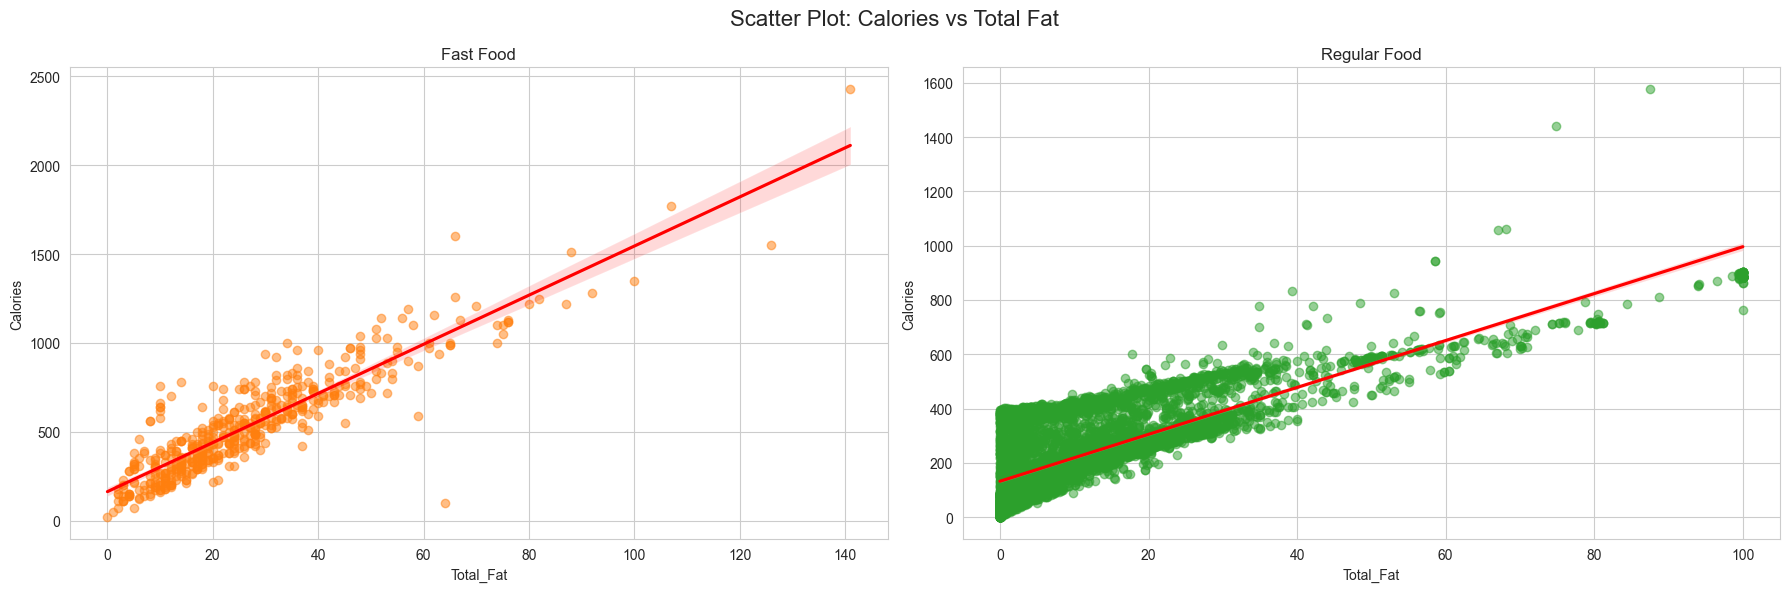

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set general style
sns.set_style("whitegrid")
numeric_cols = ['Calories', 'Total_Fat', 'Sodium', 'Sugar', 'Fiber', 'Protein']

# 1. Scatter Plot: Calories vs Total Fat with Regression Line
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Scatter Plot: Calories vs Total Fat', fontsize=16)

# Fast Food
sns.regplot(data=df_ff_clean, x='Total_Fat', y='Calories', ax=axes[0], 
            color='#ff7f0e', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0].set_title('Fast Food')

# Regular Food
sns.regplot(data=df_regular, x='Total_Fat', y='Calories', ax=axes[1], 
            color='#2ca02c', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1].set_title('Regular Food')

plt.tight_layout()
plt.show()



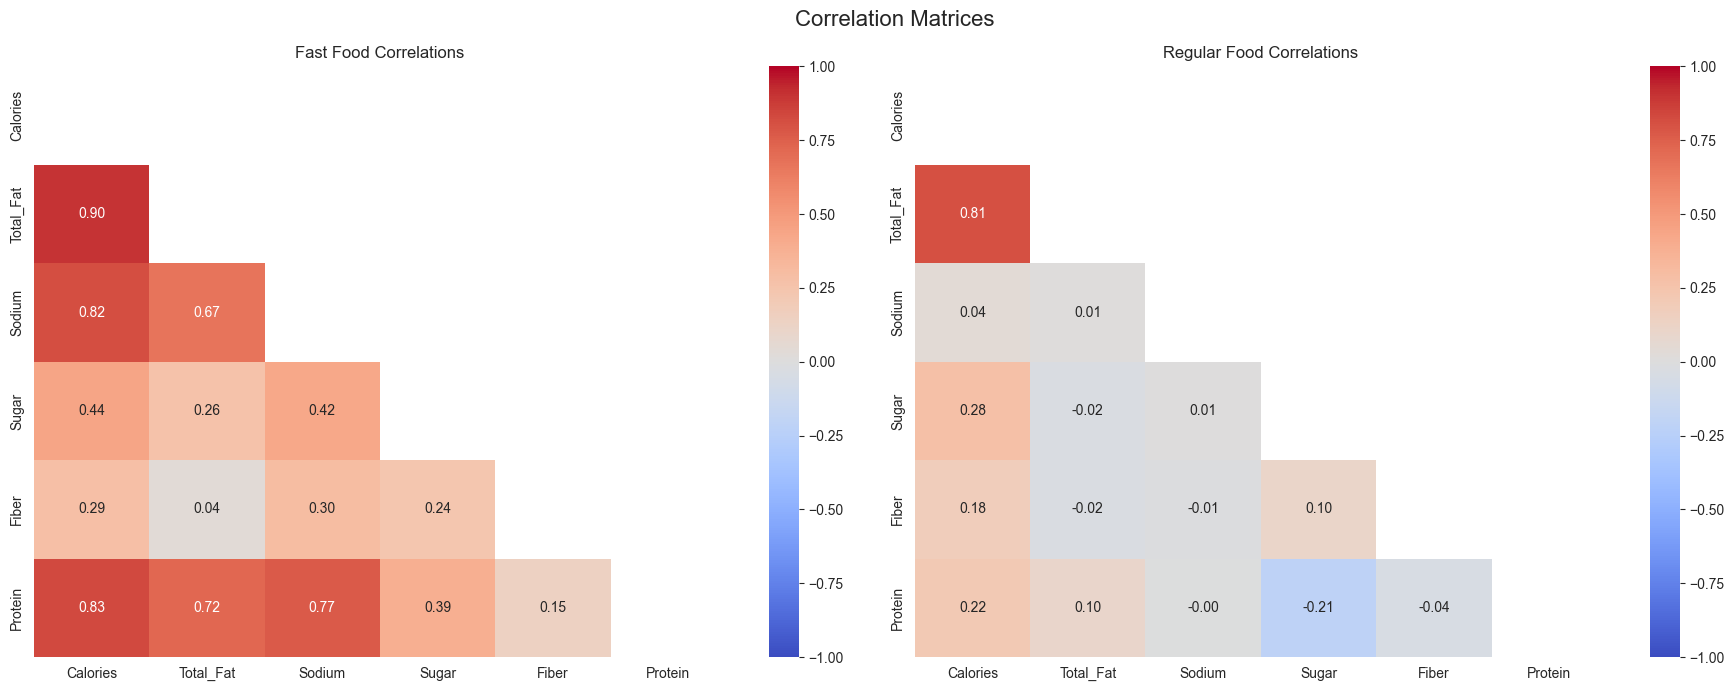

In [10]:
# 2. Heatmap of Correlations
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Correlation Matrices', fontsize=16)

# Fast Food
mask_ff = np.triu(np.ones_like(df_ff_clean[numeric_cols].corr(), dtype=bool))
sns.heatmap(df_ff_clean[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', 
            ax=axes[0], vmin=-1, vmax=1, mask=mask_ff)
axes[0].set_title('Fast Food Correlations')

# Regular Food
mask_reg = np.triu(np.ones_like(df_regular[numeric_cols].corr(), dtype=bool))
sns.heatmap(df_regular[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', 
            ax=axes[1], vmin=-1, vmax=1, mask=mask_reg)
axes[1].set_title('Regular Food Correlations')

plt.tight_layout()
plt.show()

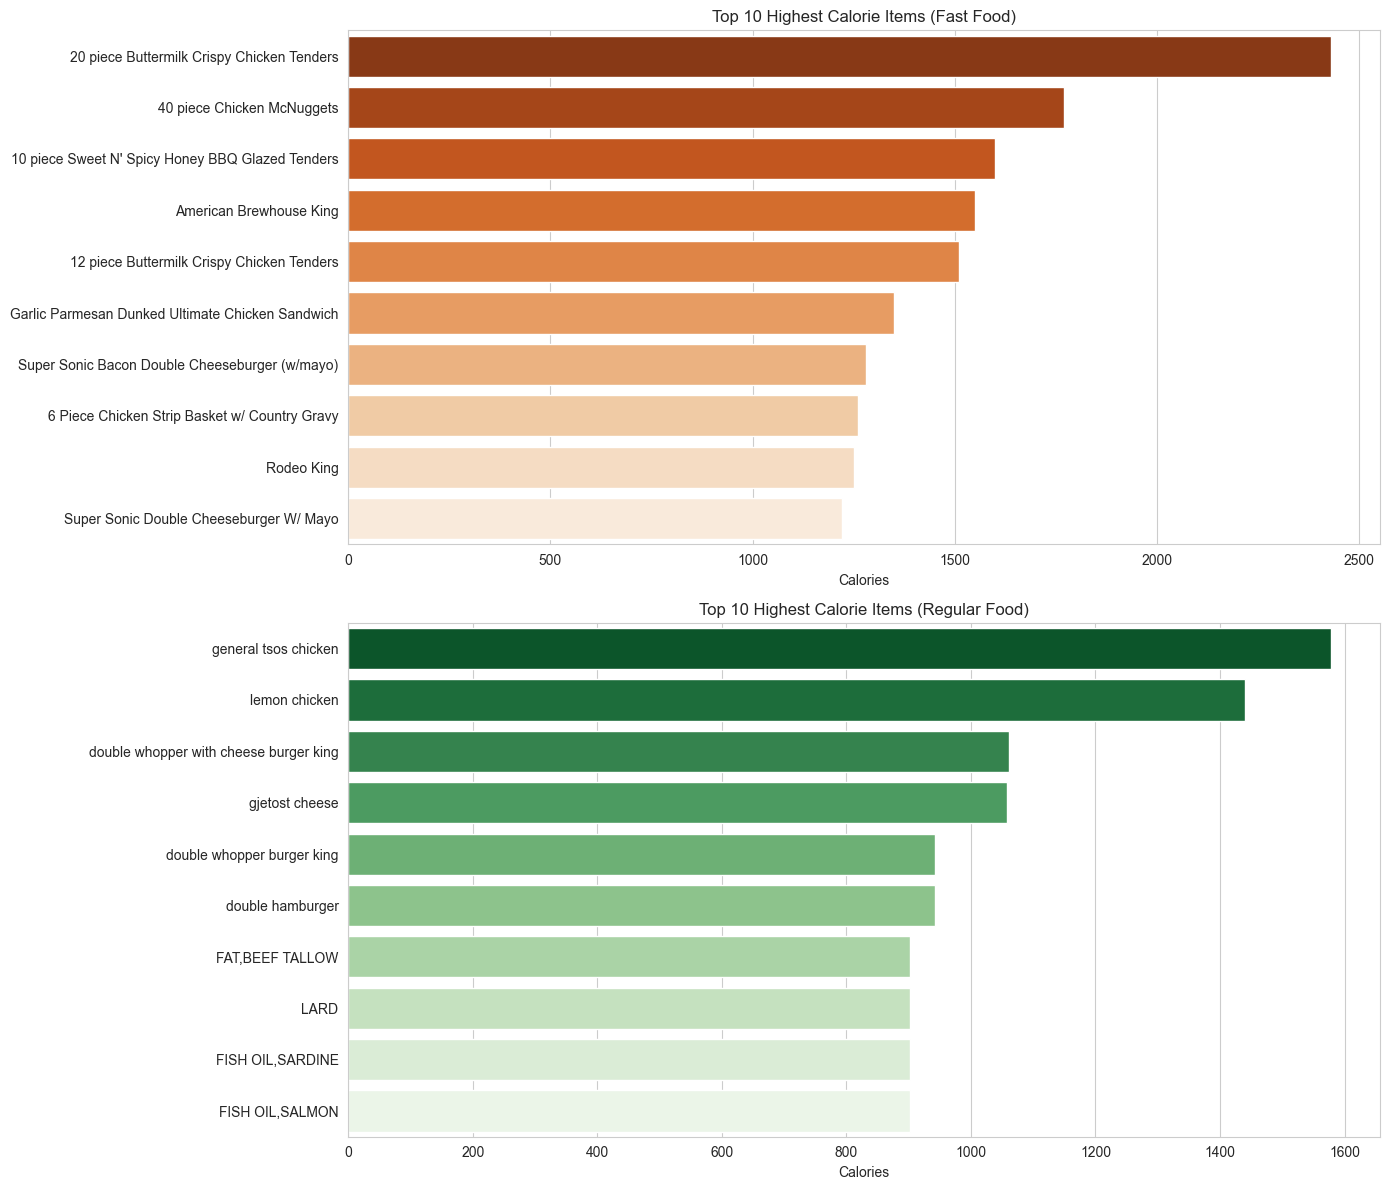

In [11]:
# 3. Barplot: Top 10 Highest Calorie Items
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Fast Food
top_10_ff = df_ff_clean.sort_values('Calories', ascending=False).head(10)
sns.barplot(data=top_10_ff, x='Calories', y='Name', ax=axes[0], palette='Oranges_r')
axes[0].set_title('Top 10 Highest Calorie Items (Fast Food)')
axes[0].set_xlabel('Calories')
axes[0].set_ylabel('')

# Regular Food
top_10_reg = df_regular.sort_values('Calories', ascending=False).head(10)
sns.barplot(data=top_10_reg, x='Calories', y='Name', ax=axes[1], palette='Greens_r')
axes[1].set_title('Top 10 Highest Calorie Items (Regular Food)')
axes[1].set_xlabel('Calories')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 2. Data Integration
We merge the Fast Food dataset with the combined Regular Food datasets into a single Master DataFrame and calculate nutritional density.

In [4]:
df_combined = pd.concat([df_ff_clean, df_regular], axis=0, ignore_index=True)

# Data Enrichment: Calculate Nutritional Density (per 100 Calories)
# This normalizes serving sizes, which allows us to compare a burger vs an apple fairly.

df_combined = df_combined.dropna(subset=['Calories'])
df_combined = df_combined[df_combined['Calories'] > 0] # Remove zero calorie items (water, diet soda)

nutrients = ['Total_Fat', 'Sodium', 'Sugar', 'Fiber', 'Protein']

for n in nutrients:
    df_combined[f'{n}_per_100cal'] = (df_combined[n] / df_combined['Calories']) * 100

print(f"Integrated Shape: {df_combined.shape}")
df_combined.head()

Integrated Shape: (8455, 14)


,Name,Calories,Total_Fat,Saturated_Fat,Sodium,Sugar,Fiber,Protein,Type,Total_Fat_per_100cal,Sodium_per_100cal,Sugar_per_100cal,Fiber_per_100cal,Protein_per_100cal
0,Artisan Grilled Chicken Sandwich,380,7.0,2.0,1110.0,11.0,3.0,37.0,Fast Food,1.842105,292.105263,2.894737,0.789474,9.736842
1,Single Bacon Smokehouse Burger,840,45.0,17.0,1580.0,18.0,2.0,46.0,Fast Food,5.357143,188.095238,2.142857,0.238095,5.476190
2,Double Bacon Smokehouse Burger,1130,67.0,27.0,1920.0,18.0,3.0,70.0,Fast Food,5.929204,169.911504,1.592920,0.265487,6.194690
3,Grilled Bacon Smokehouse Chicken Sandwich,750,31.0,10.0,1940.0,18.0,2.0,55.0,Fast Food,4.133333,258.666667,2.400000,0.266667,7.333333
4,Crispy Bacon Smokehouse Chicken Sandwich,920,45.0,12.0,1980.0,18.0,4.0,46.0,Fast Food,4.891304,215.217391,1.956522,0.434783,5.000000


## 3. Exploratory Data Analysis & Visualization
We identify the five most influential nutritional components differentiating the food types.

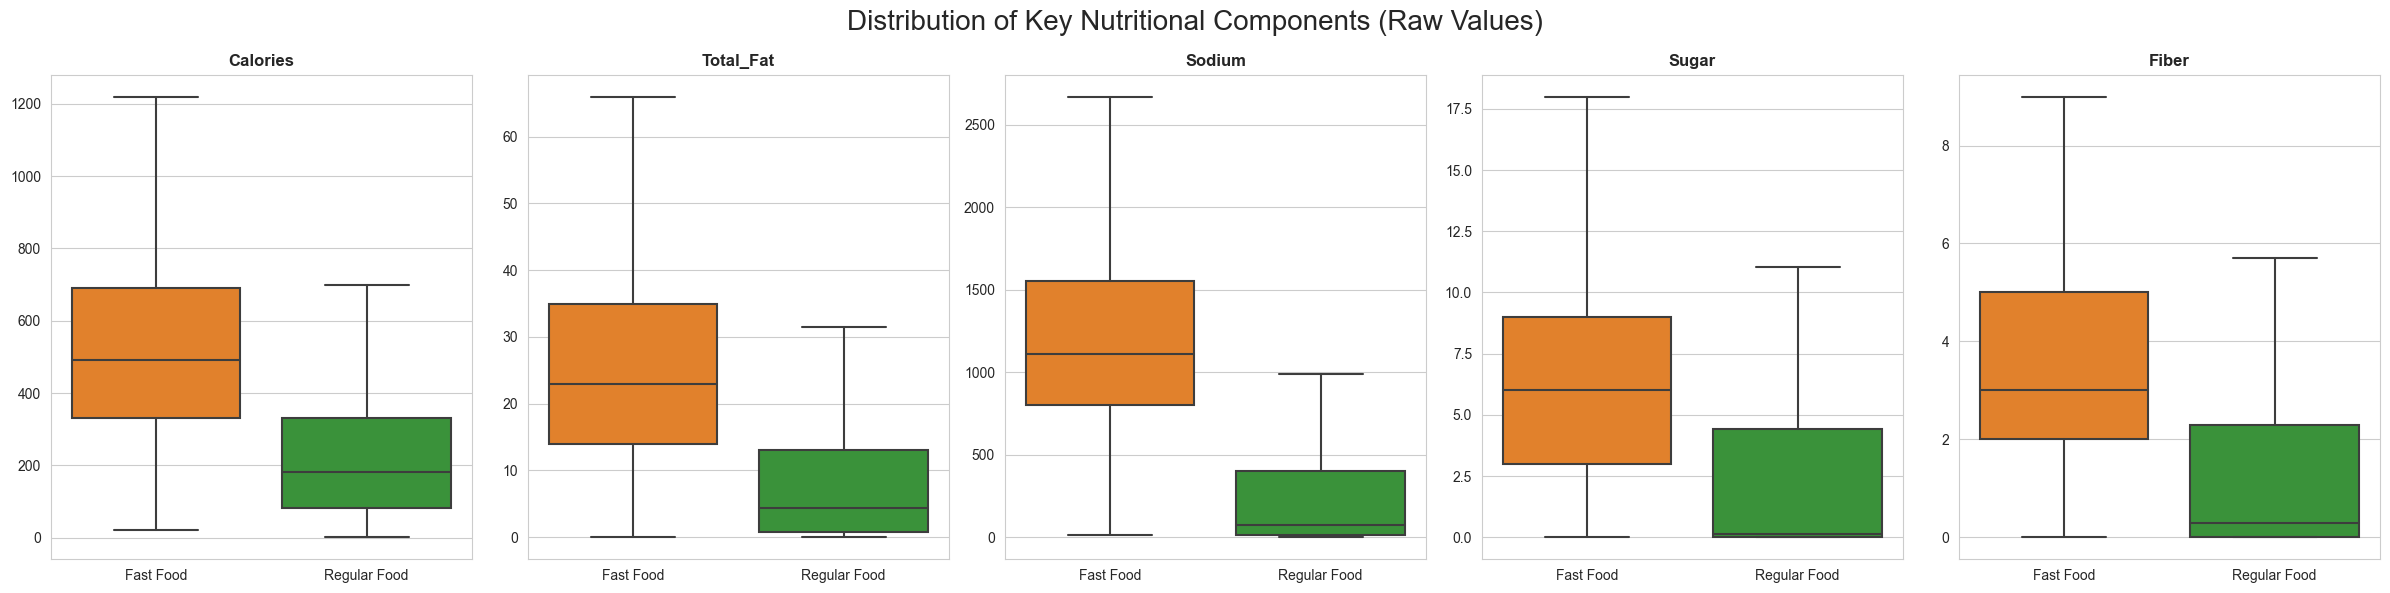

In [5]:
# Plot 1: The Big 5 Components (Raw Content)
# Checking raw distribution of Calories, Fat, Sodium, Sugar, Fiber

fig, axes = plt.subplots(1, 5, figsize=(24, 6))
fig.suptitle('Distribution of Key Nutritional Components (Raw Values)', fontsize=20)

plot_cols = ['Calories', 'Total_Fat', 'Sodium', 'Sugar', 'Fiber']
colors = {"Fast Food": "#ff7f0e", "Regular Food": "#2ca02c"}

for i, col in enumerate(plot_cols):
    sns.boxplot(data=df_combined, x='Type', y=col, ax=axes[i], palette=colors, showfliers=False)
    axes[i].set_title(col, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

### Density Analysis
Raw values can be misleading because fast food portions are often larger. Below we look at **Nutrient Density** (amount per 100 calories) to determine "Healthiness".

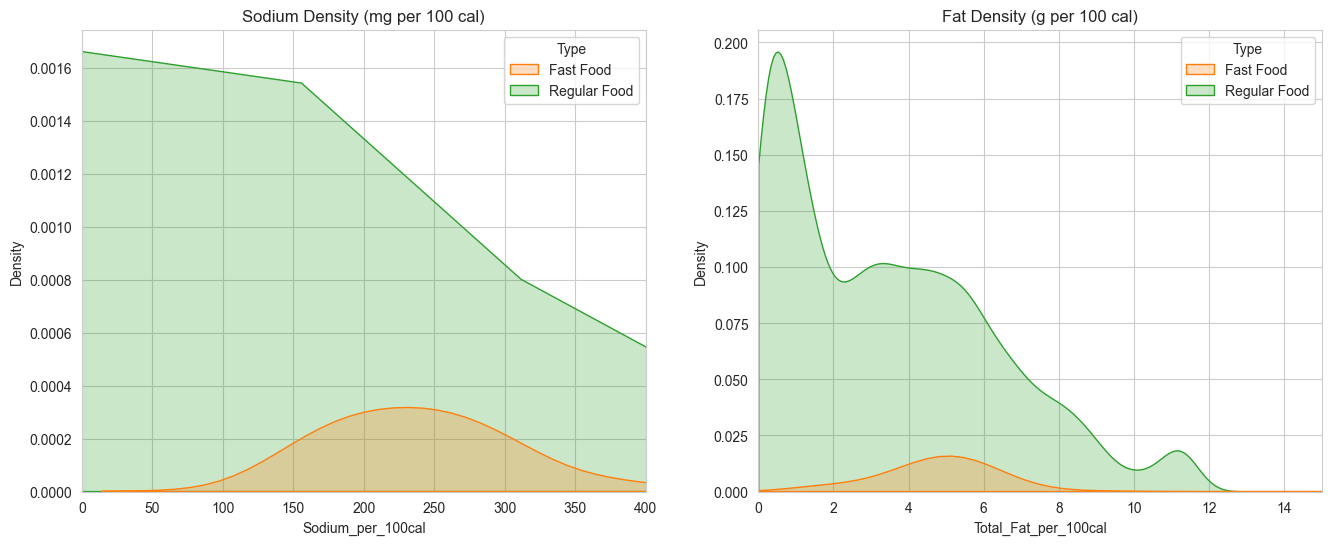

In [6]:
# Plot 2: Nutrient Density (The "Unhealthy" Signals)
# High Sodium and High Fat are often markers for unhealthy food.

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(data=df_combined, x='Sodium_per_100cal', hue='Type', fill=True, ax=axes[0], palette=colors, cut=0)
axes[0].set_title('Sodium Density (mg per 100 cal)')
axes[0].set_xlim(0, 400) # Limit x-axis to focus on the main distribution

sns.kdeplot(data=df_combined, x='Total_Fat_per_100cal', hue='Type', fill=True, ax=axes[1], palette=colors, cut=0)
axes[1].set_title('Fat Density (g per 100 cal)')
axes[1].set_xlim(0, 15)

plt.show()

### Component Correlation
Do nutrients appear together differently in fast food? (e.g., does High Fat imply High Sodium?)

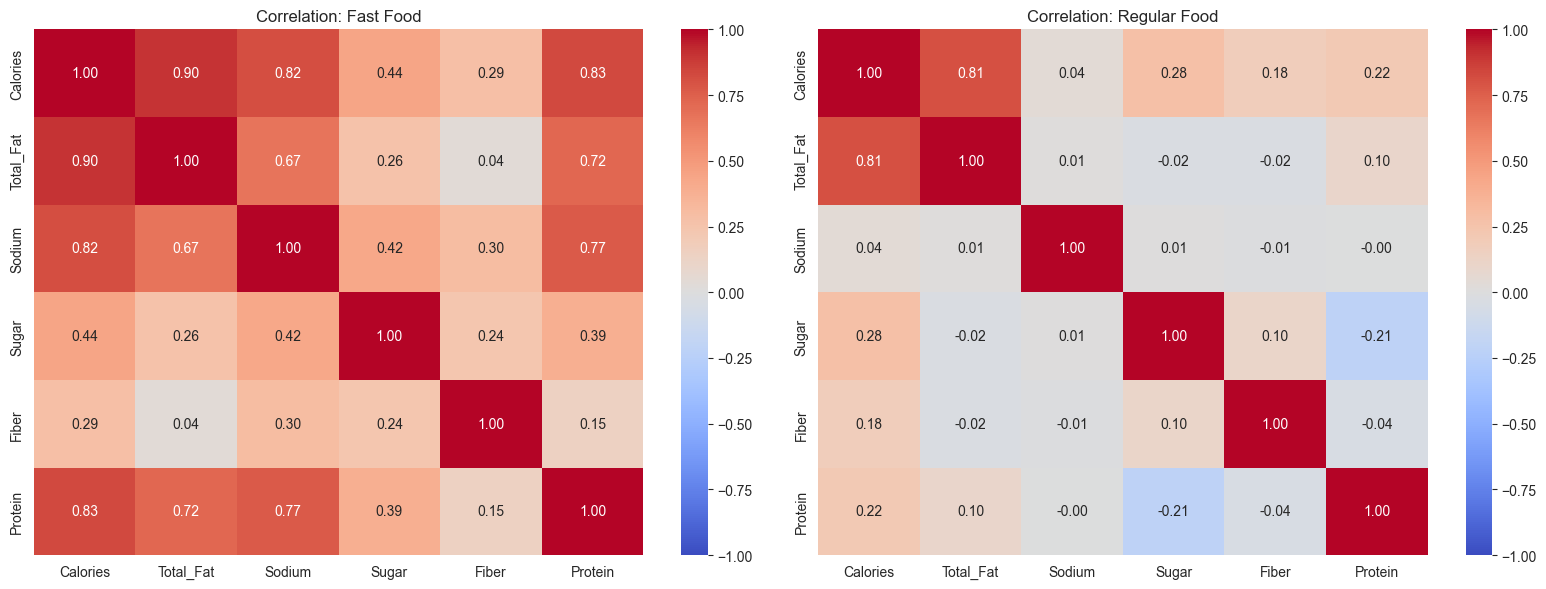

In [7]:
metrics = ['Calories', 'Total_Fat', 'Sodium', 'Sugar', 'Fiber', 'Protein']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fast Food Correlation
sns.heatmap(df_ff_clean[metrics].corr(), annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Correlation: Fast Food')

# Regular Food Correlation
sns.heatmap(df_regular[metrics].corr(), annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title('Correlation: Regular Food')

plt.tight_layout()
plt.show()

## 4. Conclusions

**1. Distinguishing Healthy vs Unhealthy:**
Based on the EDA, "Unhealthy" foods (predominantly Fast Food in this dataset) are distinguished by:
- **High Caloric Density:** Higher calories per serving.
- **Sodium Density:** Fast food has a distinctly higher sodium-to-calorie ratio than regular food.
- **Fat Consistency:** While regular food varies widely (from avocados to apples), fast food is clustered heavily in high-fat zones.

**2. Key Nutritional Components:**
The five most influential components identifying Fast Food are:
1. **Sodium:** The clearest differentiator.
2. **Total Fat:** Consistently elevated in fast food.
3. **Fiber:** Generally lower in fast food, indicating highly processed ingredients.
4. **Calories:** Fast food items generally have higher absolute calorie counts.
5. **Sugar:** Interestingly, "Regular Food" has a wider spread here (due to fruits), whereas Fast Food main dishes are low sugar, but their desserts/sides drive the average up.